In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject


In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
H5AD_V2_DIR = os.path.join(
    DATA_DIR, "abc_atlas", "expression_matrices", "WMB-10Xv2", "20230630"
)
H5AD_V3_DIR = os.path.join(
    DATA_DIR, "abc_atlas", "expression_matrices", "WMB-10Xv3", "20230630"
)


print(f"{'BASE_DIR':<15}{BASE_DIR}")
print(f"{'DATA_DIR':<15}{DATA_DIR}")
print(f"{'H5AD_V2_DIR':<15}{H5AD_V2_DIR}")
print(f"{'H5AD_V3_DIR':<15}{H5AD_V3_DIR}")

BASE_DIR       /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject
DATA_DIR       /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data
H5AD_V2_DIR    /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630
H5AD_V3_DIR    /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv3/20230630


In [3]:
hy_v2_path = os.path.join(
    H5AD_V2_DIR,
    "WMB-10Xv2-HY-log2.h5ad"
)
hy_v3_path = os.path.join(
    H5AD_V3_DIR,
    "WMB-10Xv3-HY-log2.h5ad"
)
th_v2_path = os.path.join(
    H5AD_V2_DIR,
    "WMB-10Xv2-TH-log2.h5ad"
)
th_v3_path = os.path.join(
    H5AD_V3_DIR,
    "WMB-10Xv3-TH-log2.h5ad"
)

print(f"{'hy_v2_path':<15}{hy_v2_path}")
print(f"{'hy_v3_path':<15}{hy_v3_path}")
print(f"{'th_v2_path':<15}{th_v2_path}")
print(f"{'hy_v3_path':<15}{hy_v3_path}")

hy_v2_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-HY-log2.h5ad
hy_v3_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-HY-log2.h5ad
th_v2_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-TH-log2.h5ad
hy_v3_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-HY-log2.h5ad


In [4]:
from src.utils import load_data
from src.clustering import hierarchical_clustering

In [5]:
hy_v2 = load_data(hy_v2_path, backed=None)
hy_v3 = load_data(hy_v3_path, backed=None)

# Hypothalamus

### Subregions, (depending on the organizational scheme)

- Rostral-Caudal Division (3 main regions):
    - Anterior/preoptic hypothalamus
    - Tuberal/middle hypothalamus
    - Posterior/mammillary hypothalamus

- Medial-Lateral Division (3 main zones):
    - Periventricular zone
    - Medial zone
    - Lateral hypothalamic area

--- Preprocessing ---
Batches merged


/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/.env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:703: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


Downsampled to 1000 cells
Selected top 1000 most variable genes
Preprocessing completed
---

--- Performing PCA ---


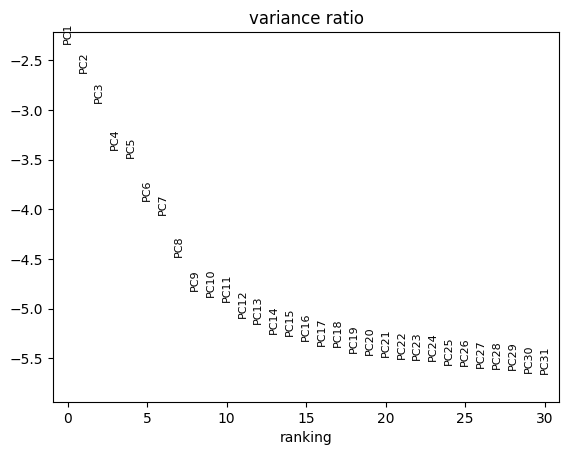

PCA completed
---

--- Finding nearest neighbors ---
Calculated nearest neighbors distance matrix using 'n_neighbors'=15
---

--- Removing noisy cells using DBSCAN ---
Using PCA as embedding method
DBSCAN ran, removing noise cells...
Noisy cells removed: 148
---

--- Clustering cells ---
--- Extracting 3 clusters from dendrogram ---
Cophenetic Correlation Coefficient: 0.7829

Rank genes groups results keys: dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])
Marker genes dataframe shape: (1001, 3)
First few rows of marker genes:
            Cluster_1           Cluster_2           Cluster_3
0  ENSMUSG00000026830  ENSMUSG00000067786  ENSMUSG00000098178
1  ENSMUSG00000013523  ENSMUSG00000015396  ENSMUSG00000030671
2  ENSMUSG00000037166  ENSMUSG00000023175  ENSMUSG00000029088
3  ENSMUSG00000022548  ENSMUSG00000058897  ENSMUSG00000026425
4  ENSMUSG00000031765  ENSMUSG00000004366  ENSMUSG00000022587
Total unique top marker genes found: 15
Final marker genes list 

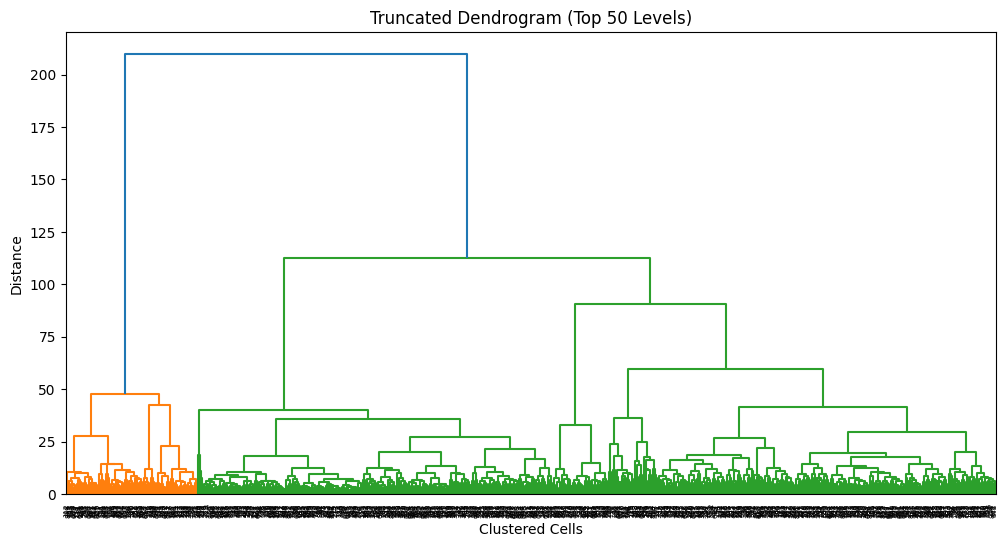

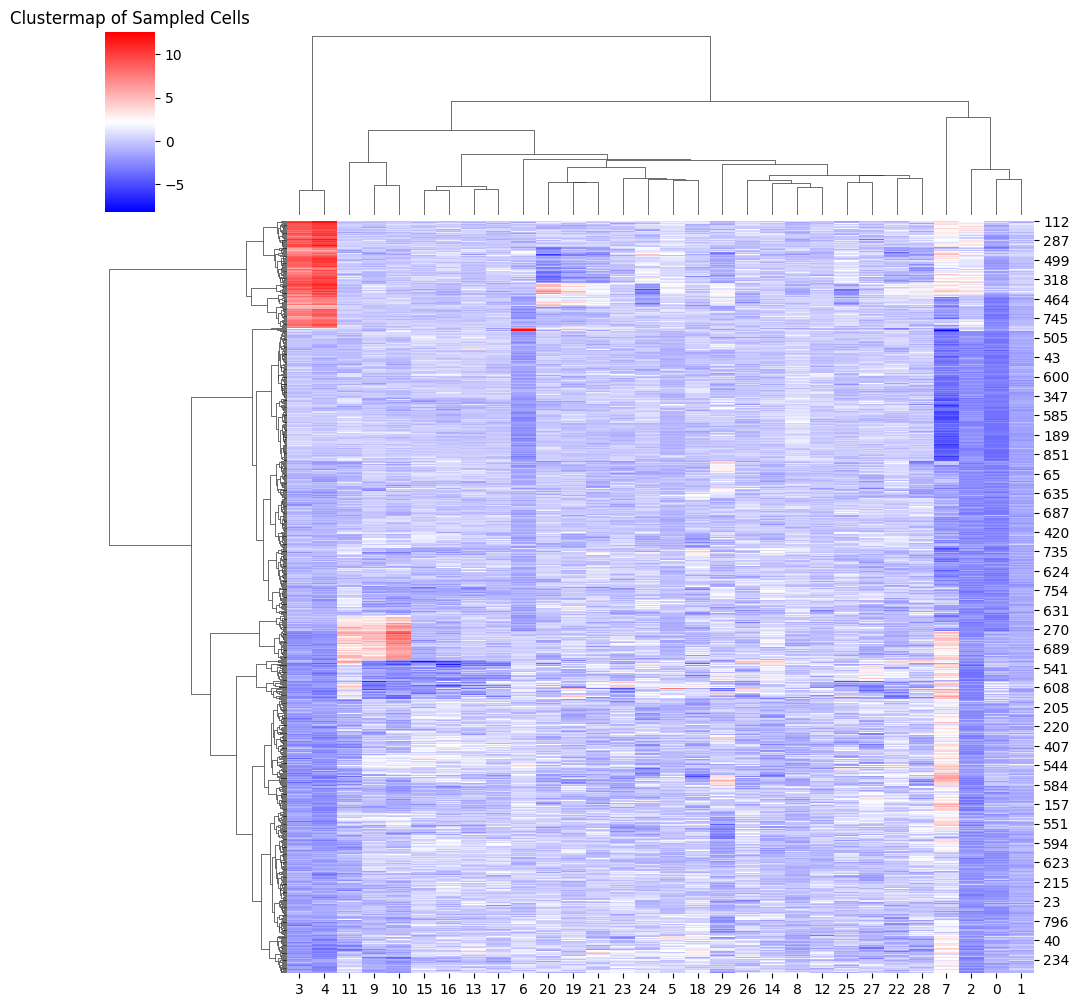

Top marker genes for visualization: ['ENSMUSG00000004366', 'ENSMUSG00000022587', 'ENSMUSG00000031765', 'ENSMUSG00000022548', 'ENSMUSG00000015396', 'ENSMUSG00000023175', 'ENSMUSG00000058897', 'ENSMUSG00000029088', 'ENSMUSG00000026830', 'ENSMUSG00000030671']...
Generating dendrogram with aligned heatmaps...
Number of marker genes provided: 15
First 10 marker genes: ['ENSMUSG00000004366', 'ENSMUSG00000022587', 'ENSMUSG00000031765', 'ENSMUSG00000022548', 'ENSMUSG00000015396', 'ENSMUSG00000023175', 'ENSMUSG00000058897', 'ENSMUSG00000029088', 'ENSMUSG00000026830', 'ENSMUSG00000030671']
Number of valid marker genes found in data: 15
Expression data shape: (852, 15)
Scaled expression data shape: (852, 15)


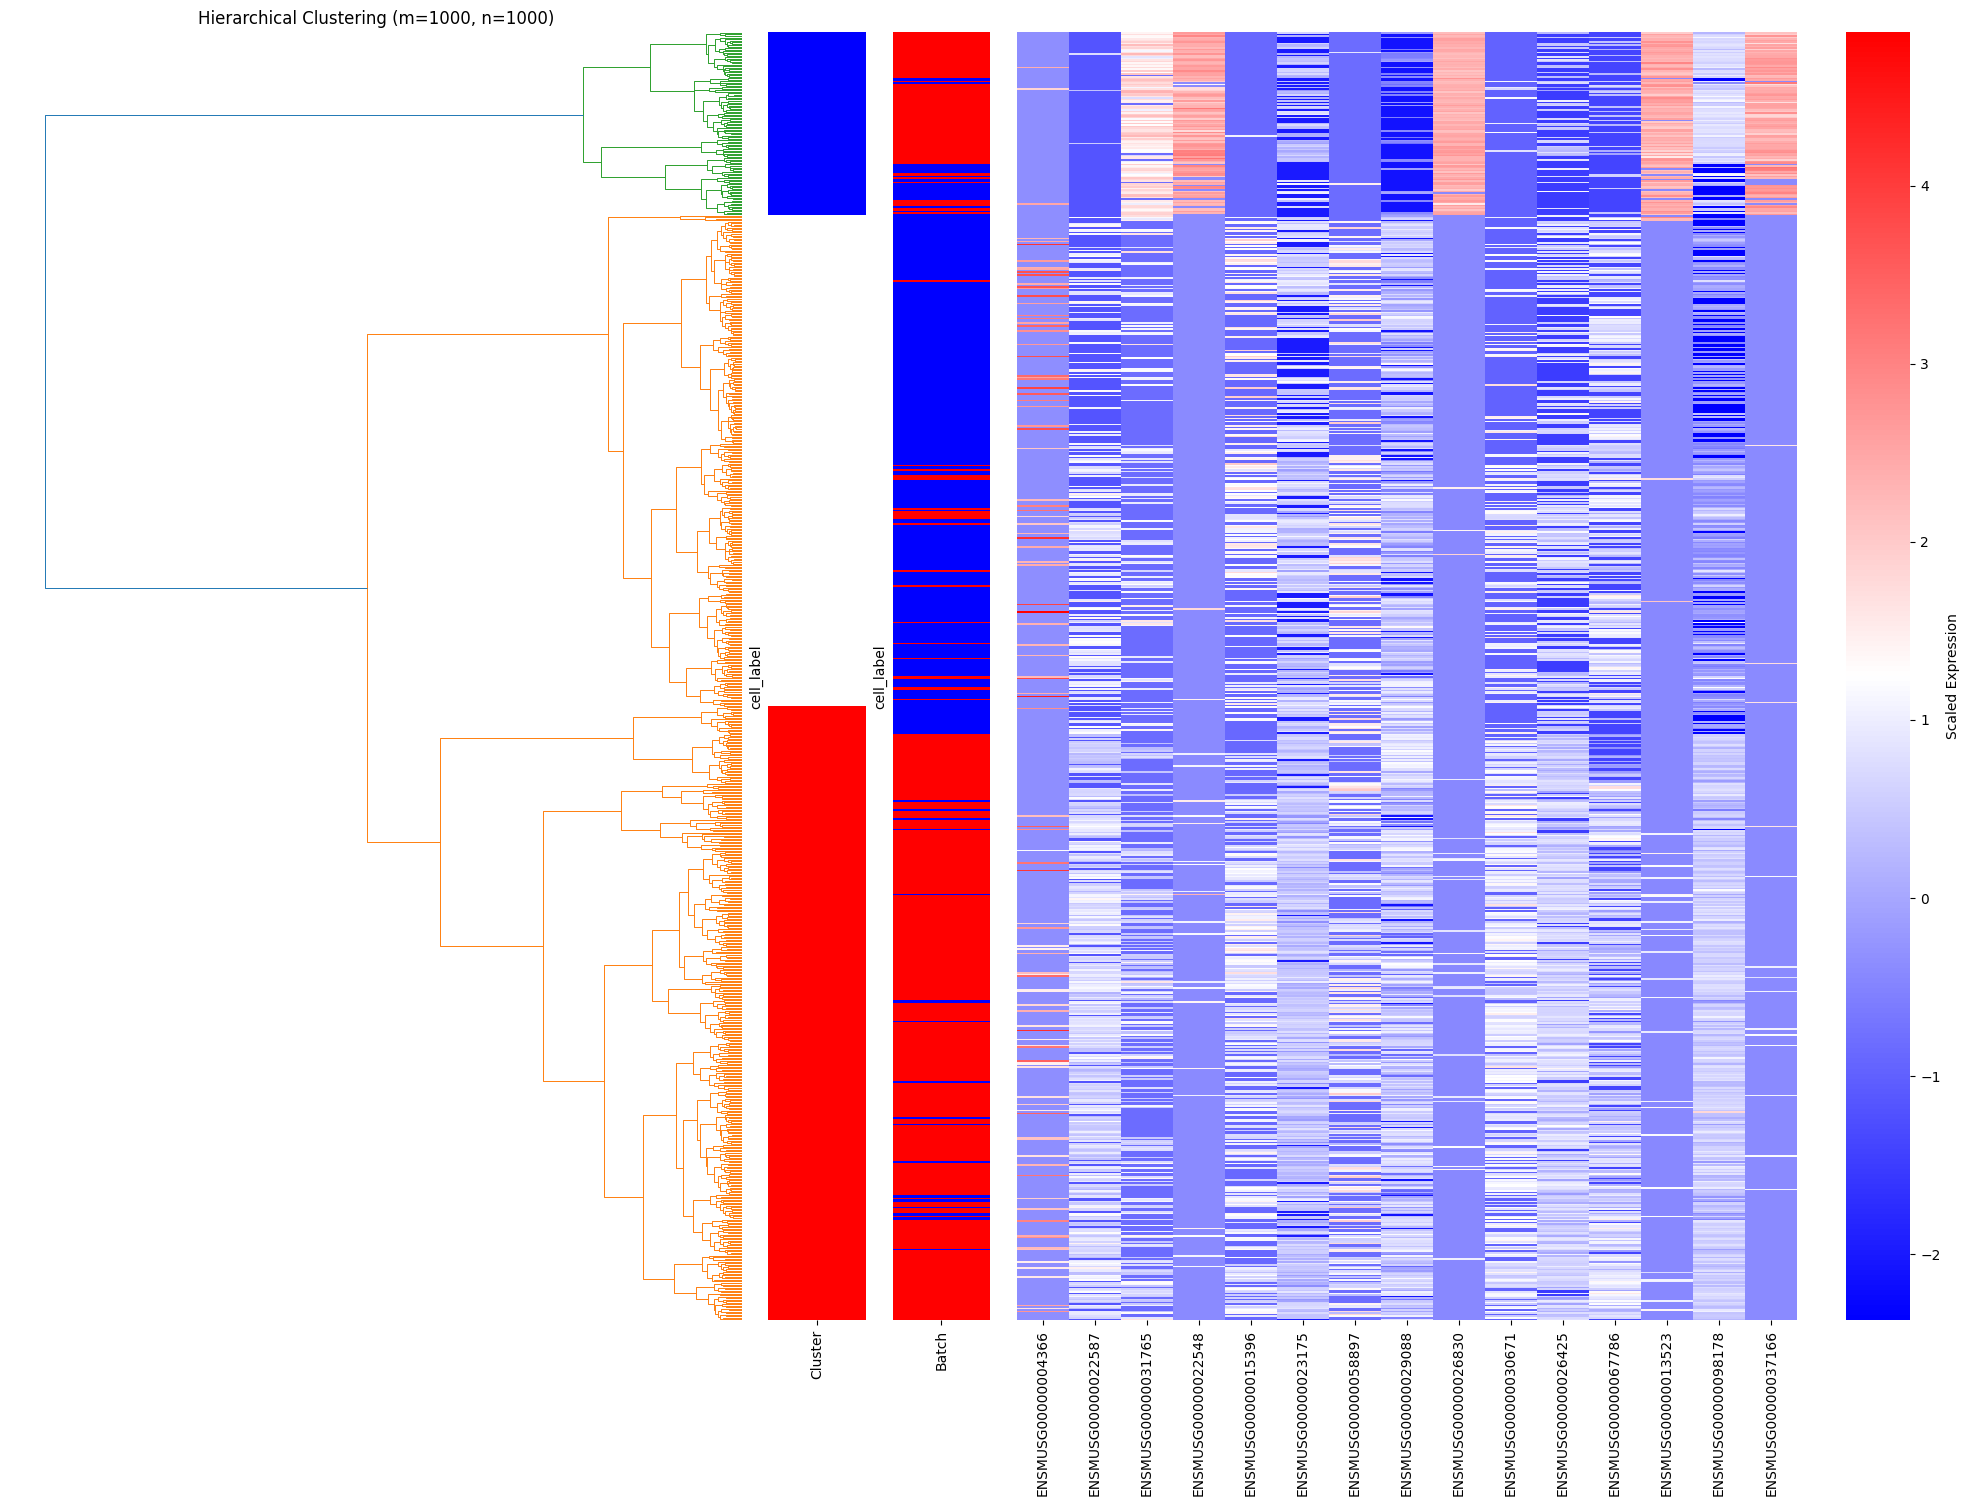

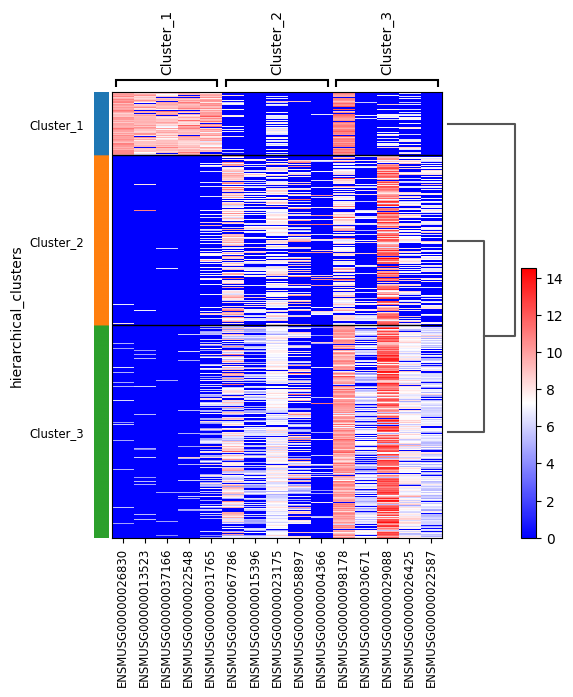

---



In [6]:
n = 1_000
m = 1_000
n_pcs = 4
min_pts = 40
eps = 2.55
num_clusters = 3

hierarchical_clustering(
        batches=[hy_v2, hy_v3],
        batch_keys=["hy_v2", "hy_v3"],
        num_clusters=num_clusters,
        min_pts=min_pts,
        eps=eps,
        n_pcs=n_pcs,
        n=n,
        m=m,
)